# All models

Juan Carlos Provencio Lameiras

Nathanael Ediger

Daniel Drost

## Plot options

In [1]:
from cycler import cycler
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = 0.5
rcParams['axes.labelsize'] = 20
rcParams['axes.prop_cycle'] = cycler('color', ['#C61A27', '#3891A6', \
                                               '#F79D65', '#FDE74C'])
rcParams['axes.titlesize'] = 22
rcParams['figure.figsize'] = (12, 7)
rcParams['figure.titlesize'] = 26
rcParams['font.size'] = 16
rcParams['image.cmap'] = 'magma'
rcParams['lines.markeredgewidth'] = 2
rcParams['lines.markerfacecolor'] = 'white'
rcParams['markers.fillstyle'] = 'none'

## Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

# Tools
import time
from tqdm import tqdm
import os
import glob

ModuleNotFoundError: No module named 'torchvision'

## Data

In [ ]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

# Task 1: Intro (ReLU Model)

In [ ]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

def find_latest_checkpoint(checkpoint_dir, 
                           root = "checkpoint_intro_epoch_*.pth"):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, root))
    
    if not checkpoint_files:
        return None
    
    checkpoint_files.sort(key = os.path.getmtime)
    return checkpoint_files[-1]

# Remember to implement a checkpoint!!
# Especially since my laptop takes longer than 1 hour to run this
def load_checkpoint(filepath):
    # Saved checkpoint in case of crash
    checkpoint = torch.load(filepath)
    start_epoch = checkpoint['epoch']
    w_h, w_h2, w_o = checkpoint['model_state_dict']
    optimizer = RMSprop(params = [w_h, w_h2, w_o])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_loss = checkpoint['train_loss']
    test_loss = checkpoint['test_loss']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    return (start_epoch, w_h, w_h2, w_o, optimizer, 
            train_loss, test_loss, train_accuracy, test_accuracy)


# Can you load from checkpoint?
checkpoint_dir = '.'
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    (start_epoch, w_h, w_h2, w_o, optimizer, 
     train_loss, test_loss, train_accuracy, test_accuracy) \
        = load_checkpoint(latest_checkpoint)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    print("Starting from scratch...")


n_epochs = 100


# put this into a training loop over 100 epochs
for epoch in tqdm(range(start_epoch + 1, n_epochs + 1)):
    train_loss_this_epoch = []
    train_correct = 0
    
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()
        
        # Calculate accuracy
        train_correct += (torch.argmax(noise_py_x, dim=1) == y).sum().item()

    train_loss.append(np.mean(train_loss_this_epoch))
    train_accuracy.append(train_correct / len(train_dataset))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        print(f"Train Accuracy: {train_accuracy[-1]:.2%}")
        test_loss_this_epoch = []
        test_correct = 0

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))
                # Calculate accuracy
                test_correct += (torch.argmax(noise_py_x, dim=1) == y).sum().item()


        test_loss.append(np.mean(test_loss_this_epoch))
        test_accuracy.append(test_correct / len(test_dataset))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
        print(f"Test Accuracy: {test_accuracy[-1]:.2%}")
        
        # Save model checkpoints
        torch.save({
            'epoch': epoch,
            'model_state_dict': [w_h, w_h2, w_o],
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, f'checkpoint_intro_epoch_{epoch}.pth')


0it [00:00, ?it/s]

Resuming training from epoch 100


<div style="color: green; font-weight: bold">
    A bit more robust than sample solution.
    
    For this task, we only had to import the code, make sure that all the required packages were compatible with the python, numpy, etc. versions we had installed and have it run once. This worked, at least for 2/3 members of the group and we then ran the code.
    
    We quickly realized that the process of training was extremely slow, taking upwards of 1 hour in our old laptops. In order to mitigate possible issues during the run, we decided to directly implement a checkpoint-saver every 10 runs.
</div> 

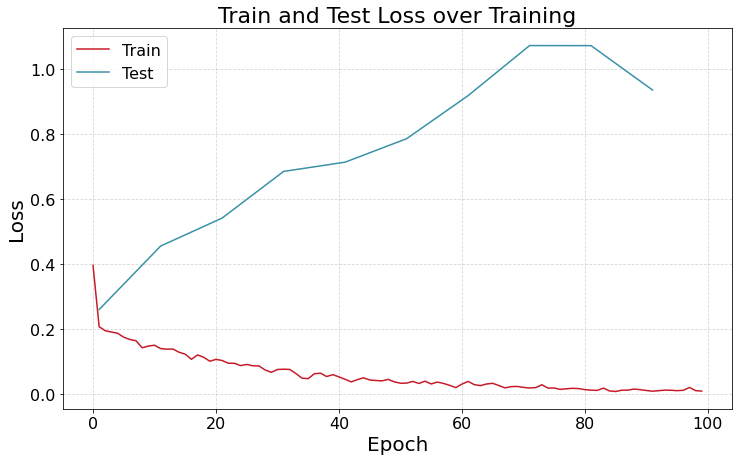

In [ ]:
# Loss plot
intro_train_loss = train_loss
intro_test_loss = test_loss
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_loss, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_loss, 
         label = "Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss_intro.png')

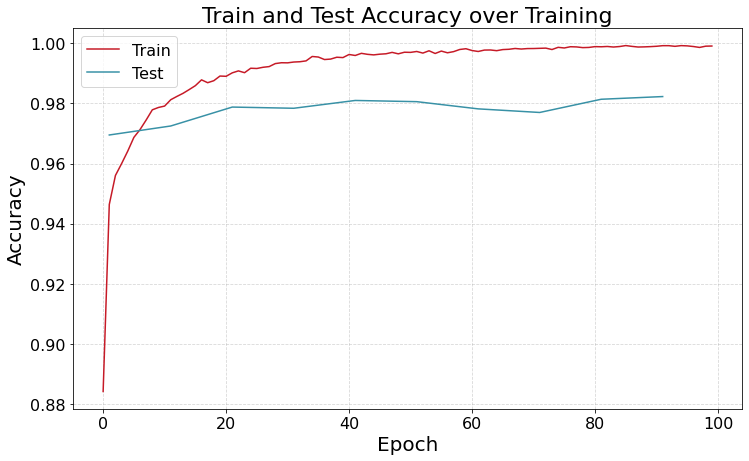

In [ ]:
# Accuracy plot
intro_train_accuracy = train_accuracy
intro_test_accuracy = test_accuracy
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_accuracy, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_accuracy, 
         label = "Test")
plt.title("Train and Test Accuracy over Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_intro.png')

<div style="color: green; font-weight: bold">
    Additionally, we included the accuracy of the network over the epochs.
</div> 

## Task 2: Dropout model

In [ ]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size = shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


# Return weighted dropout
# Apparently, torch doesn't like playing with other kids. Use torch.rand
# instead of python's other methods, such as numpy random or scipy binom.
def dropout(X, p_drop = 0.3):
    if p_drop < 0 or p_drop >= 1:
        return X 
    
    mask = (torch.rand(X.shape) < 1 - p_drop).float()
    X = X * mask / (1 - p_drop)
    return X

<div style="color: green; font-weight: bold">
    Our implementation is nearly identical to one of the examples in the sample solution. However, we accidentally applied the mask on all items from a uniform random distribution with `< 1 - p_drop` instead of `< p_drop` 
</div> 

In [ ]:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr = 1e-4, alpha = 0.5, eps = 1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])
                
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

# Remember to implement a checkpoint!!
# Especially since my laptop takes longer than 1 hour to run this
def load_checkpoint(filepath):
    # Saved checkpoint in case of crash
    checkpoint = torch.load(filepath)
    start_epoch = checkpoint['epoch']
    w_h, w_h2, w_o = checkpoint['model_state_dict']
    optimizer = RMSprop(params = [w_h, w_h2, w_o])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_loss = checkpoint['train_loss']
    test_loss = checkpoint['test_loss']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    return (start_epoch, w_h, w_h2, w_o, optimizer, 
            train_loss, test_loss, train_accuracy, test_accuracy)

def find_latest_checkpoint(checkpoint_dir, 
                           root = "checkpoint_dropout_epoch_*.pth"):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, root))
    
    if not checkpoint_files:
        return None
    
    checkpoint_files.sort(key = os.path.getmtime)
    return checkpoint_files[-1]


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

# dropout probabilities
p_drop_input = 0.5
p_drop_hidden = 0.5

optimizer = RMSprop(params=[w_h, w_h2, w_o])
            
# Can you load from checkpoint?
checkpoint_dir = '.'
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    (start_epoch, w_h, w_h2, w_o, optimizer, 
     train_loss, test_loss, train_accuracy, test_accuracy) \
        = load_checkpoint(latest_checkpoint)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    print("Starting from scratch...")

n_epochs = 100

# Mark this as the start_time:
start_time = time.time()

# put this into a training loop over 100 epochs
for epoch in tqdm(range(start_epoch + 1, n_epochs + 1)):
    train_loss_this_epoch = []
    train_correct = 0
    
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o,
                                   p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction = "mean")
        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()
        
        # Calculate accuracy
        train_correct += (torch.argmax(noise_py_x, dim=1) == y).sum().item()

    train_loss.append(np.mean(train_loss_this_epoch))
    train_accuracy.append(train_correct / len(train_dataset))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        print(f"Train Accuracy: {train_accuracy[-1]:.2%}")
        test_loss_this_epoch = []
        test_correct = 0

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction = "mean")
                test_loss_this_epoch.append(float(loss))
                # Calculate accuracy
                test_correct += (torch.argmax(noise_py_x, dim=1) == y).sum().item()

        test_loss.append(np.mean(test_loss_this_epoch))
        test_accuracy.append(test_correct / len(test_dataset))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
        print(f"Test Accuracy: {test_accuracy[-1]:.2%}")
        
        # Save model checkpoints
        torch.save({
            'epoch': epoch,
            'model_state_dict': [w_h, w_h2, w_o],
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, f'checkpoint_dropout_epoch_{epoch}.pth')
        
    end_time = time.time()

0it [00:00, ?it/s]

Resuming training from epoch 100


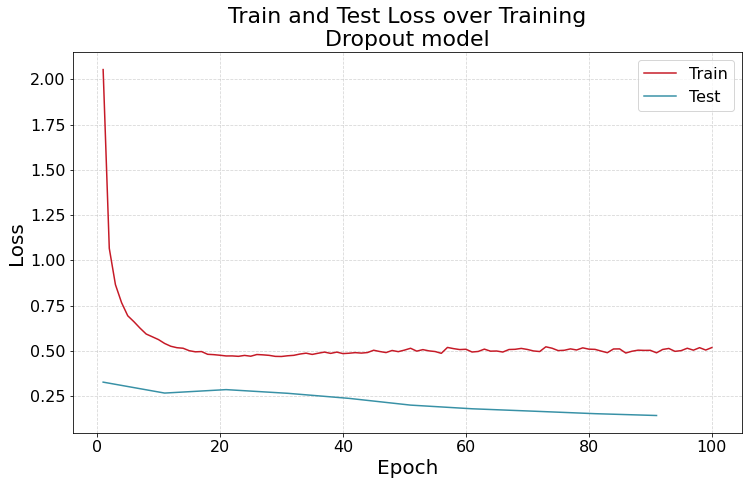

In [ ]:
# Loss plot
dropout_train_loss = train_loss
dropout_test_loss = test_loss
plt.figure()
plt.plot(np.arange(1, len(train_loss) + 1), 
         train_loss, 
         label = "Train")
plt.plot(np.arange(1, len(test_loss) * 10 + 1, 10), 
         test_loss, 
         label = "Test")
plt.title("Train and Test Loss over Training\nDropout model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss_dropout.png')

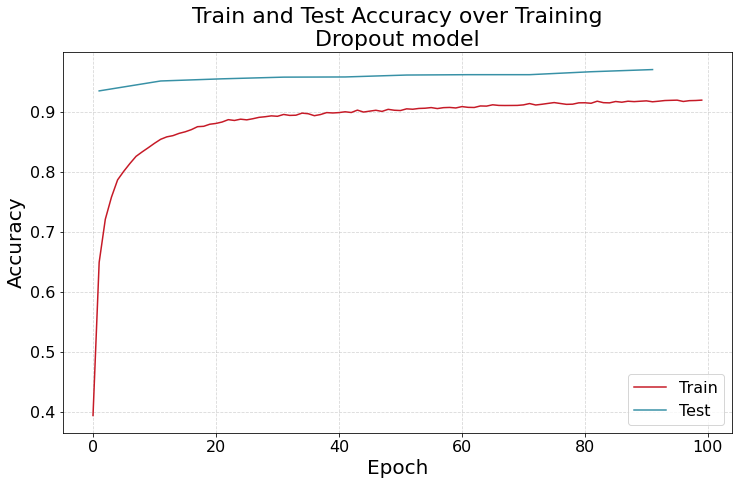

In [ ]:
# Accuracy plot
dropout_train_accuracy = train_accuracy
dropout_test_accuracy = test_accuracy
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_accuracy, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_accuracy, 
         label = "Test")
plt.title("Train and Test Accuracy over Training\nDropout model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_dropout.png')

<div style="color: green; font-weight: bold">
    In general similar comments to the ones from the first task. The implementation of a checkpoint is a nice extra and the accuracy is, apart from the loss, a good measure to see how the network is learning. Especially considering that although the network improves, according to the accuracy, the loss in the sample solution appears to continue increasing.
    
    We forgot to answer the question regarding how dropout helps reduce overfitting. In general one could say that it prevents the network from learning specific very prominent features.
</div> 

## Task 3: Parametric model

In [ ]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size = shape) * std
    w.requires_grad = True
    return w

def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


# If x > 0: return x, else: return a * x
# Use min, max functions for case discrimination
def PReLU(x, a):
    # Parametric ReLU
    return (torch.max(x, torch.zeros_like(x)) 
            + a * torch.min(x, torch.zeros_like(x)))

# Return weighted dropout
# Apparently, torch doesn't like playing with other kids. Use torch.rand
# instead of python's other methods, such as numpy random or scipy binom.
def dropout(X, p_drop = 0.3):
    if p_drop < 0 or p_drop >= 1:
        return X 
    
    mask = (torch.rand(X.shape) < 1 - p_drop).float()
    X = X * mask / (1 - p_drop)
    return X


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr = 1e-4, alpha = 0.5, eps = 1e-8):
        defaults = dict(lr = lr, alpha = alpha, eps = eps)
        super(RMSprop, self).__init__(params, defaults)

    # This automatically calculates the gradient and updates for every
    # learnable parameter.
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                ### RELEVANT ERROR AREA ###
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])
                
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

# Same as ReLU model, but with PReLU
def parametric_model(X, w_h, w_h2, w_o, a):
    h = PReLU(X @ w_h, a)
    h2 = PReLU(h @ w_h2, a)
    pre_softmax = h2 @ w_o
    return pre_softmax


def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

# Remember to implement a checkpoint!!
# Especially since my laptop takes longer than 1 hour to run this
def load_checkpoint(filepath):
    # Saved checkpoint in case of crash
    checkpoint = torch.load(filepath)
    start_epoch = checkpoint['epoch']
    w_h, w_h2, w_o, a = checkpoint['model_state_dict']
    optimizer = RMSprop(params = [w_h, w_h2, w_o, a])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_loss = checkpoint['train_loss']
    test_loss = checkpoint['test_loss']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    return (start_epoch, w_h, w_h2, w_o, optimizer, 
            train_loss, test_loss, train_accuracy, test_accuracy)

def find_latest_checkpoint(checkpoint_dir, 
                           root = "checkpoint_parametric_epoch_*.pth"):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, root))
    
    if not checkpoint_files:
        return None
    
    checkpoint_files.sort(key = os.path.getmtime)
    return checkpoint_files[-1]


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

# Initialize a as a 0x0 tensor with gradient requirement
a = torch.tensor(0.25, requires_grad = True)


# REMEMBER: Include "a" from PReLU as a learnable param
optimizer = RMSprop(params = [w_h, w_h2, w_o, a])
            
# Can you load from checkpoint?
checkpoint_dir = '.'
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    (start_epoch, w_h, w_h2, w_o, optimizer, 
     train_loss, test_loss, train_accuracy, test_accuracy) \
        = load_checkpoint(latest_checkpoint)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    print("Starting from scratch...")


n_epochs = 100


# Mark this as the start_time:
start_time = time.time()

# put this into a training loop over 100 epochs
for epoch in tqdm(range(start_epoch + 1, n_epochs + 1)):
    train_loss_this_epoch = []
    train_correct = 0
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = parametric_model(x, w_h, w_h2, w_o, a)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction = "mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()
        
        # Calculate accuracy
        train_correct += (torch.argmax(noise_py_x, dim = 1) == y).sum().item()

    train_loss.append(np.mean(train_loss_this_epoch))
    train_accuracy.append(train_correct / len(train_dataset))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        print(f"Train Accuracy: {train_accuracy[-1]:.2%}")
        test_loss_this_epoch = []
        test_correct = 0

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = parametric_model(x, w_h, w_h2, w_o, a)

                loss = cross_entropy(noise_py_x, y, reduction = "mean")
                test_loss_this_epoch.append(float(loss))
                
                # Calculate accuracy
                test_correct += (torch.argmax(noise_py_x, dim=1) == y).sum().item()

        test_loss.append(np.mean(test_loss_this_epoch))
        test_accuracy.append(test_correct / len(test_dataset))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
        print(f"Test Accuracy: {test_accuracy[-1]:.2%}")
        
        # Save model checkpoints
        torch.save({
            'epoch': epoch,
            'model_state_dict': [w_h, w_h2, w_o, a],
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, f'checkpoint_parametric_epoch_{epoch}.pth')
        
    end_time = time.time()
    

  0%|          | 0/100 [00:00<?, ?it/s]

Starting from scratch...


  9%|▉         | 9/100 [01:37<16:48, 11.08s/it]

Epoch: 10
Mean Train Loss: 4.69e-02
Train Accuracy: 98.58%


 10%|█         | 10/100 [01:52<18:08, 12.09s/it]

Mean Test Loss:  8.59e-02
Test Accuracy: 97.47%


 19%|█▉        | 19/100 [03:50<18:04, 13.39s/it]

Epoch: 20
Mean Train Loss: 1.19e-02
Train Accuracy: 99.66%


 20%|██        | 20/100 [04:07<19:06, 14.33s/it]

Mean Test Loss:  8.85e-02
Test Accuracy: 97.65%


 29%|██▉       | 29/100 [06:10<16:23, 13.85s/it]

Epoch: 30
Mean Train Loss: 3.33e-03
Train Accuracy: 99.91%


 30%|███       | 30/100 [06:28<17:30, 15.00s/it]

Mean Test Loss:  1.02e-01
Test Accuracy: 98.02%


 39%|███▉      | 39/100 [08:37<14:45, 14.51s/it]

Epoch: 40
Mean Train Loss: 1.25e-03
Train Accuracy: 99.96%


 40%|████      | 40/100 [08:54<15:14, 15.24s/it]

Mean Test Loss:  1.13e-01
Test Accuracy: 98.10%


 49%|████▉     | 49/100 [11:01<12:04, 14.21s/it]

Epoch: 50
Mean Train Loss: 5.15e-04
Train Accuracy: 99.99%


 50%|█████     | 50/100 [11:19<12:41, 15.23s/it]

Mean Test Loss:  1.31e-01
Test Accuracy: 98.05%


 59%|█████▉    | 59/100 [13:28<09:49, 14.37s/it]

Epoch: 60
Mean Train Loss: 5.59e-04
Train Accuracy: 99.99%


 60%|██████    | 60/100 [13:46<10:16, 15.42s/it]

Mean Test Loss:  1.40e-01
Test Accuracy: 98.22%


 69%|██████▉   | 69/100 [15:41<06:09, 11.93s/it]

Epoch: 70
Mean Train Loss: 1.57e-04
Train Accuracy: 99.99%


 70%|███████   | 70/100 [15:55<06:16, 12.54s/it]

Mean Test Loss:  1.63e-01
Test Accuracy: 98.03%


<div style="color: green; font-weight: bold">
    For some reason, when running the code this time we got an error:
</div> 

<div style="color: red; font-weight: bold">
    AttributeError: 'NoneType' object has no attribute 'data'
</div> 

<div style="color: green; font-weight: bold">
    referring to grad = p.grad.data.
    
    Last time, this didn't cause any issues, so we implemented a quick if block to circumvent this here. It can be that some library we used previously was a different version, since many libraries were updated in the last couple of days.
</div> 

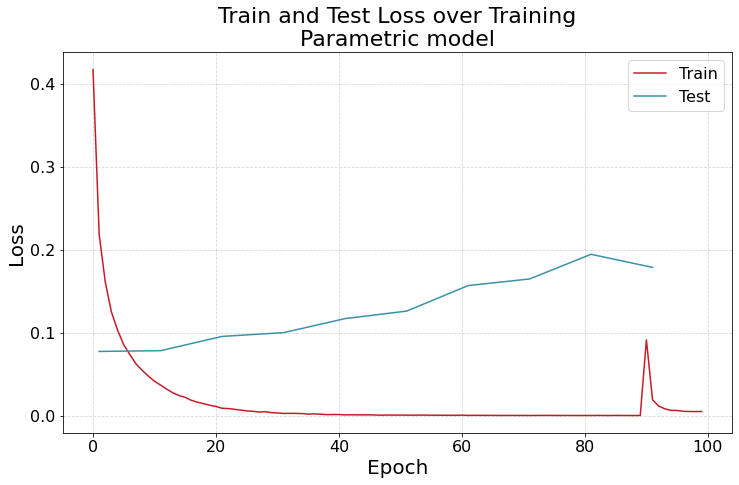

In [ ]:
# Loss plot
parametric_train_loss = train_loss
parametric_test_loss = test_loss
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_loss, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_loss, 
         label = "Test")
plt.title("Train and Test Loss over Training\nParametric model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss_parametric.png')

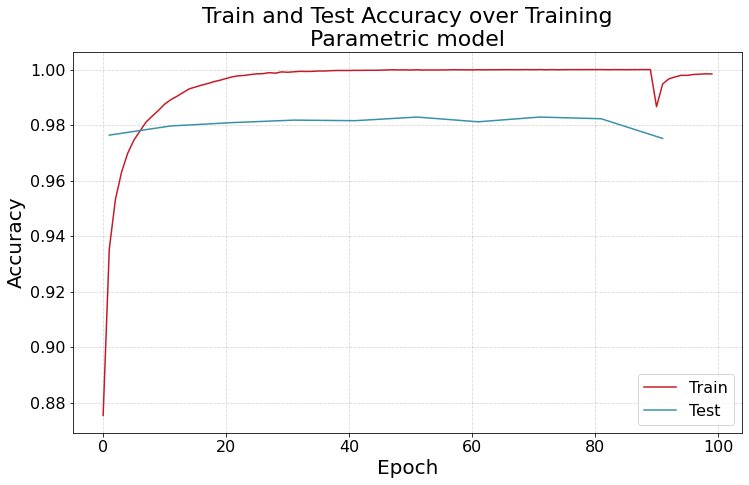

In [ ]:
# Accuracy plot
parametric_train_accuracy = train_accuracy
parametric_test_accuracy = test_accuracy
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_accuracy, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_accuracy, 
         label = "Test")
plt.title("Train and Test Accuracy over Training\nParametric model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_parametric.png')

<div style="color: green; font-weight: bold">
    For the parametric model, we only considered including the parameter alpha, but not additionally a dropout model. While we considered implementing this as well, we didn't have the time anymore due to how long the convolutional network was taking to run (~5 hours). Our initialization of alpha was also different, since we weren't sure what value to pick. We decided it to leave arbitrarily at 0.25.
</div> 

## Model comparison

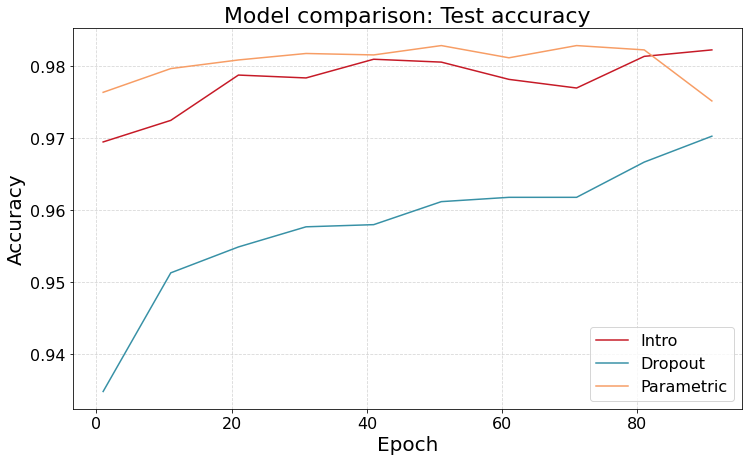

In [ ]:
plt.figure()
plt.title('Model comparison: Test accuracy')
plt.plot(np.arange(1, n_epochs + 1, 10), 
         intro_test_accuracy, 
         label = "Intro")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         dropout_test_accuracy, 
         label = "Dropout")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         parametric_test_accuracy, 
         label = "Parametric")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.savefig('Model_comparison.png')

## Task 4: Convolutional Neural Network

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch import optim
from tqdm import tqdm

def init_weights(shape):
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w

def rectify(x):
    return F.relu(x)

class RMSprop(optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)
                square_avg = state['square_avg']
                alpha = group['alpha']
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])
                p.data.addcdiv_(grad, avg, value=-group['lr'])
                
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

# Remember to implement a checkpoint!!
# Especially since my laptop takes longer than 1 hour to run this
def load_checkpoint(filepath):
    # Saved checkpoint in case of crash
    checkpoint = torch.load(filepath)
    start_epoch = checkpoint['epoch']
    w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o = checkpoint['model_state_dict']
    optimizer = RMSprop(params = [w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_loss = checkpoint['train_loss']
    test_loss = checkpoint['test_loss']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    return (start_epoch, w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o, optimizer, 
            train_loss, test_loss, train_accuracy, test_accuracy)

def find_latest_checkpoint(checkpoint_dir, 
                           root = "checkpoint_CNN_epoch_*.pth"):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, root))
    
    if not checkpoint_files:
        return None
    
    checkpoint_files.sort(key = os.path.getmtime)
    return checkpoint_files[-1]

# Initialize weights for convolutional layers
w_conv1 = init_weights((32, 1, 5, 5))
w_conv2 = init_weights((64, 32, 5, 5))
w_conv3 = init_weights((128, 64, 3, 3))

# Flatten layer weights
w_h = init_weights((128 * 3 * 3, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop(params = [w_conv1, w_conv2, w_conv3, 
                              w_h, w_h2, w_o])

# Can you load from checkpoint?
checkpoint_dir = '.'
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    (start_epoch, w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o, optimizer, 
     train_loss, test_loss, train_accuracy, test_accuracy) \
        = load_checkpoint(latest_checkpoint)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    print("Starting from scratch...")

def model(x, w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o):
    x = x.view(-1, 1, 28, 28)
    c1 = rectify(F.conv2d(x, w_conv1, stride=1, padding=2))
    p1 = F.max_pool2d(c1, (2, 2))
    d1 = F.dropout(p1, p=0.25)
    
    c2 = rectify(F.conv2d(d1, w_conv2, stride=1, padding=2))
    p2 = F.max_pool2d(c2, (2, 2))
    d2 = F.dropout(p2, p=0.25)
    
    c3 = rectify(F.conv2d(d2, w_conv3, stride=1, padding=1))
    p3 = F.max_pool2d(c3, (2, 2))
    d3 = F.dropout(p3, p=0.25)
    
    flatten = d3.view(-1, 128 * 3 * 3)
    h = rectify(flatten @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

<div style="color: green; font-weight: bold">
    
</div> 

In [ ]:
n_epochs = 100

# put this into a training loop over 100 epochs
for epoch in tqdm(range(start_epoch + 1, n_epochs + 1)):
    train_loss_this_epoch = []
    train_correct = 0
    
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        # feed input through model
        noise_py_x = model(x, w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = F.cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()
        
        # Calculate accuracy
        train_correct += (torch.argmax(noise_py_x, dim=1) == y).sum().item()

    train_loss.append(np.mean(train_loss_this_epoch))
    train_accuracy.append(train_correct / len(train_dataset))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        print(f"Train Accuracy: {train_accuracy[-1]:.2%}")
        test_loss_this_epoch = []
        test_correct = 0

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                noise_py_x = model(x, w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o)

                loss = F.cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))
                # Calculate accuracy
                test_correct += (torch.argmax(noise_py_x, dim = 1) == y).sum().item()

        test_loss.append(np.mean(test_loss_this_epoch))
        test_accuracy.append(test_correct / len(test_dataset))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
        print(f"Test Accuracy: {test_accuracy[-1]:.2%}")
        
        # Save model checkpoints
        torch.save({
            'epoch': epoch,
            'model_state_dict': [w_conv1, w_conv2, w_conv3, w_h, w_h2, w_o],
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, f'checkpoint_CNN_epoch_{epoch}.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Starting from scratch...


  3%|▎         | 3/100 [08:33<4:36:54, 171.28s/it]

<div style="color: green; font-weight: bold">
The implementation is good though the training seems to take an unexpected amount of time. 
So we did not have time to train the model completley in the end.
It was obviously not necessary to reimplement the earlier functions, but it seemed easier to remain overview this way.

</div> 

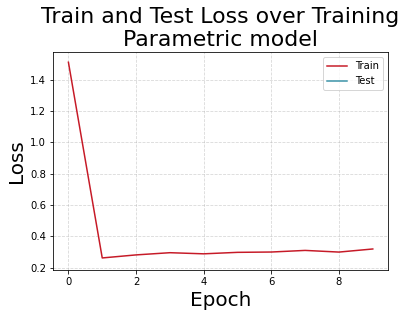

In [ ]:
# Loss plot
cnn_train_loss = train_loss
cnn_test_loss = test_loss
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_loss, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_loss, 
         label = "Test")
plt.title("Train and Test Loss over Training\nParametric model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss_parametric.png')

<div style="color: green; font-weight: bold">
   The training-loss shows expected results.
   The test-loss is not shown as we did not train our model long enough.
</div> 

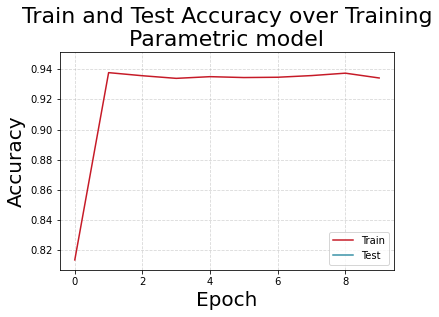

In [ ]:
# Accuracy plot
cnn_train_accuracy = train_accuracy
cnn_test_accuracy = test_accuracy
plt.figure()
plt.plot(np.arange(n_epochs), 
         train_accuracy, 
         label = "Train")
plt.plot(np.arange(1, n_epochs + 1, 10), 
         test_accuracy, 
         label = "Test")
plt.title("Train and Test Accuracy over Training\nParametric model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_parametric.png')

<div style="color: green; font-weight: bold">
   The accuracy was not necessary to be plottet. As expectation dictates it is inverted to the loss plot. 
</div> 